In [1]:
import polynomial_matching as pm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rawpy
import pandas as pd

## Read images

In [2]:
raw_images = []
for i in range(1,6):
    raw = cv2.imread('data/image/Canon1DsMkIII_000{}.tiff'.format(i), cv2.IMREAD_UNCHANGED)
    raw_images.append(cv2.demosaicing(raw, cv2.COLOR_BAYER_BG2BGR))

## Read patch color

In [3]:
patches = []
for i in range(1, 6):
    rawpatch = pd.read_csv('data/checker/Canon1DsMkIII_000{}_color.txt'.format(i), names=['1','2','3']).to_numpy() # access to the RAW image
    # patches.append(gammaCorrection(normIm(rawpatch,darkness_level,saturation_level)))
    patches.append(rawpatch)
    
print(patches[0])

[[2692.3 3776.2 2079. ]
 [2051.4 2753.2 1706.4]
 [1664.2 2109.4 1447.1]
 [1384.6 1630.7 1258.6]
 [1214.1 1346.7 1148.1]
 [1107.5 1163.4 1075.8]
 [1115.4 1248.7 1283.5]
 [1331.4 1831.6 1179.5]
 [1507.7 1295.7 1095.3]
 [2368.4 2861.3 1206.1]
 [1657.7 1519.9 1347.5]
 [1239.  1728.  1474. ]
 [1961.5 1789.8 1117.9]
 [1198.  1399.5 1395.7]
 [1685.7 1450.6 1174.1]
 [1184.6 1240.6 1168.8]
 [1789.3 2470.7 1226. ]
 [2130.7 2306.  1150.1]
 [1292.4 1337.5 1111.5]
 [1818.1 1916.8 1316.5]
 [1247.1 1490.4 1285.3]
 [1203.4 1364.8 1087.6]
 [1454.  1762.8 1459.9]
 [1589.8 2485.8 1562. ]]


## pre-processing

In [4]:
def normIm(image, darkness, saturation):
    '''Normalize the image to [0,1]'''
    return (image-darkness)/(saturation-darkness)

In [5]:
# determined by camera
darkness_level = 1024.
saturation_level = 15279.

In [6]:
norm_images = []
for im in raw_images:
    norm_images.append(normIm(im, darkness_level, saturation_level))
for i in range(len(patches)):
    patches[i] = normIm(patches[i], darkness_level, saturation_level)

In [7]:
def brightCorrection(image, patch):
    '''Adjust the brightness of the image'''
    # RGB转灰度 RGB 0.299, 0.587, 0.114
    grayMean = np.mean(image[:,:,0])*0.114 + np.mean(image[:,:,1])*0.587 + np.mean(image[:,:,2])*0.299
    grayScale = 0.25/grayMean
    rtn = image*grayScale
    patch = patch*grayScale
    rtn[rtn>1] = 1
    patch[patch>1] = 1
    return rtn, patch

In [8]:
def gammaCorrection(image, gamma=2.2):
    '''Convert linear RGB to sRGB with gammaCorrection'''
    invgamma = 1 / gamma
    return (np.power(image, invgamma)*255).astype(np.uint8)

In [9]:
sRGB_images = []
for im in range(len(norm_images)):
    bright_im, patches[im] = brightCorrection(norm_images[im], patches[im])
    sRGB_images.append(cv2.cvtColor(gammaCorrection(bright_im),cv2.COLOR_BGR2RGB))
    patches[im] = gammaCorrection(patches[im])

C:\Users\HP\AppData\Local\Temp/ipykernel_26148/99706111.py:4: RuntimeWarning: invalid value encountered in power
  return (np.power(image, invgamma)*255).astype(np.uint8)


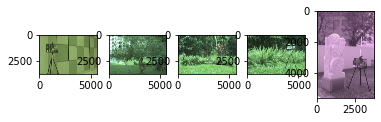

In [10]:
fig, ax = plt.subplots(1, 5)

ax[0].imshow(sRGB_images[0])
ax[1].imshow(sRGB_images[1])
ax[2].imshow(sRGB_images[2])
ax[3].imshow(sRGB_images[3])
ax[4].imshow(sRGB_images[4])
plt.show()

In [11]:
for idx in range(1,5):
    cv2.imwrite('data/image/Canon1DsMkIII_0001_000{}_origin.png'.format(idx), cv2.cvtColor(sRGB_images[idx-1], cv2.COLOR_RGB2BGR))

## Matching

In [12]:
stdmatch = []
stdimages = []
for i in range(0, len(patches)):
    stdmatch.append(pm.polyCoeff(patches[i], pm.ColorChecker2005_sRGB))
    stdmatch[-1].to_npy('data/Canon1DsMkIII_000{}.npy'.format(i))
    stdimages.append(stdmatch[-1].transform(sRGB_images[i]))

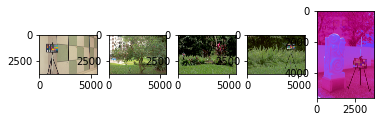

In [13]:
fig, ax = plt.subplots(1, 5)

ax[0].imshow(stdimages[0])
ax[1].imshow(stdimages[1])
ax[2].imshow(stdimages[2])
ax[3].imshow(stdimages[3])
ax[4].imshow(stdimages[4])
plt.show()

In [14]:
for idx in range(1,5):
    cv2.imwrite('data/image/Canon1DsMkIII_000{}_std.png'.format(idx), cv2.cvtColor(stdimages[idx-1], cv2.COLOR_RGB2BGR))

In [15]:
uniquematch=[]
uniqueimages=[]
for i in range(0, len(patches)-1):
    uniquematch.append(pm.polyCoeff(pm.ColorChecker2005_sRGB, patches[i]))
    uniquematch[-1].to_npy('data/Canon1DsMkIII_000{}_trans.npy'.format(i))
    uniqueimages.append(uniquematch[-1].transform(stdimages[0]))

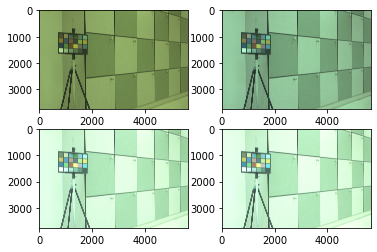

In [16]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(uniqueimages[0])
ax[0, 1].imshow(uniqueimages[1])
ax[1, 0].imshow(uniqueimages[2])
ax[1, 1].imshow(uniqueimages[3])
plt.show()

In [17]:
for idx in range(1,5):
    cv2.imwrite('data/image/Canon1DsMkIII_0001_000{}_transfer.png'.format(idx), cv2.cvtColor(uniqueimages[idx-1], cv2.COLOR_RGB2BGR))

## Chromatic Adaption

In [27]:
def chromaticAdaption(image, illuminant):
    '''Perform chromatic adaption on a image according to the given illuminant'''
    norm_image = image - np.min(image) / np.max(image) - np.min(image)
    scale = 1 / illuminant * 255
    rtn = norm_image * scale
    rtn[rtn>255] = 255
    return rtn.astype(np.uint8)

In [28]:
ground_truths = np.array([
    [0.294924662865143,0.809736795789161,0.507292583011997],
    [0.529726222721315,0.773168710868106,0.348712307634760],
    [0.522898409552397,0.776450991980404,0.351711686385626],
    [0.522821592760223,0.780197730492675,0.343437160886446],
    [0.570550344894225,0.754279603770420,0.324860867567979]
])

chromas = []
for i in range(4):
    chromas.append(cv2.cvtColor(chromaticAdaption(norm_images[i], ground_truths[i]), cv2.COLOR_BGR2RGB))

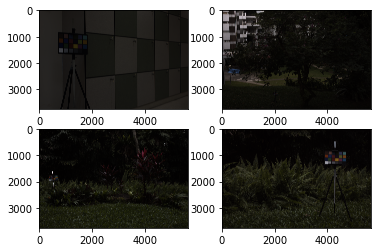

In [29]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(chromas[0])
ax[0, 1].imshow(chromas[1])
ax[1, 0].imshow(chromas[2])
ax[1, 1].imshow(chromas[3])
plt.show()